## **Deep Learning for Causal Inference by Vikas Ramachandra**

Applying the concepts from the "Deep Learning for Causal Inference" paper authored by Vikas Ramachandra to the data_for_churn_analysis dataset

link to the paper: <a>https://arxiv.org/abs/1803.00149</a>

In [9]:
# DA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ML
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors


import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout


# Metrics
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error, mean_absolute_error

In [2]:
# Loading dataset
df = pd.read_csv('data_for_churn_analysis.csv')

In [3]:
df.shape

(104143, 18)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104143 entries, 0 to 104142
Data columns (total 18 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   device                                 104025 non-null  object 
 1   first_payment_amount                   104143 non-null  int64  
 2   age                                    104001 non-null  float64
 3   city                                   98301 non-null   object 
 4   number_of_cards                        103671 non-null  float64
 5   payments_initiated                     103671 non-null  float64
 6   payments_failed                        103671 non-null  float64
 7   payments_completed                     103671 non-null  float64
 8   payments_completed_amount_first_7days  103671 non-null  float64
 9   reward_purchase_count_first_7days      80879 non-null   float64
 10  coins_redeemed_first_7days             103671 non-null  

In [5]:
# null values?
print(f"{df.isnull().sum().sum()=}")
print(f"perc of dataset missing {df.isnull().sum().sum()/df.shape[0]}")

df.isnull().sum().sum()=37490
perc of dataset missing 0.3599857887712088


In [6]:
# proportion of people who have churned
df['is_churned'].value_counts(normalize=True)

is_churned
0    0.713192
1    0.286808
Name: proportion, dtype: float64

### 1. **Impact of Referrals on Customer Acquisition and Retention**:
   - Research Question: Do customers acquired through referrals (`is_referral`) exhibit different behaviors and retention rates compared to non-referred customers?
   - Treatment: Customer acquisition through referrals
   - Outcome: Customer behavior (e.g., `payments_initiated`, `payments_completed`, `visits_feature_1`, `visits_feature_2`) and churn (`is_churned`)
   - Potential Confounders: `device`, `age`, `city`, `number_of_cards`, `payments_failed`, `payments_completed_amount_first_7days`, `reward_purchase_count_first_7days`, `coins_redeemed_first_7days`, `given_permission_1`, `given_permission_2`

$$Y_i = f(T_i, X_i, \epsilon_i)$$

Where:

- $Y_i$ represents the outcome variable `is_churned` for customer $i$
- $T_i$ is the treatment variable `is_referral`, indicating whether customer $i$ was acquired through a referral
- $X_i$ represents the vector of potential confounding variables for customer $i$, such as `device`, `age`, `city`, `number_of_cards`, `payments_failed`, `payments_completed_amount_first_7days`, `reward_purchase_count_first_7days`, `coins_redeemed_first_7days`, `given_permission_1`, `given_permission_2`
- $\epsilon_i$ is the error term, accounting for unobserved factors affecting the outcome
- $f$ is an unknown function that maps the treatment, confounders, and error term to the outcome

In [7]:
# -------------- DATA PREPROCESSING --------------------

# Encoding using label encoding technique
obj_cols = df.select_dtypes(include='object').columns # grabs object dtypes columns
le = LabelEncoder() # creates LabelEncoder instance
for col in obj_cols:
    df[col] = le.fit_transform(df[col]) # encodes each column

df['is_referral'] = np.where(df['is_referral'] == True, 1, 0)


# -------------- IMPUTING MISSING VALUES --------------------
missing_cols = df.columns[df.isna().any()].tolist()
for col in missing_cols:
    df[col] = df[col].fillna(df[col].mean())


# -------------- DATA SPLIT --------------------

confounders = [
    'device',
    'age',
    'city',
    'number_of_cards',
    'payments_failed',
    'payments_completed_amount_first_7days',
    'reward_purchase_count_first_7days',
    'coins_redeemed_first_7days',
    'given_permission_1',
    'given_permission_2',
    'is_referral' # treatment
]

y = df['is_churned']
X = df[confounders]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
Y_train, Y_test = train_test_split(y, test_size=0.2, random_state=42)

**PCA**

In [10]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
X_pca = pca.fit_transform(X_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Compute nearest neighbors in the reduced-dimensional space obtained from PCA
nbrs_pca = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(X_pca)
distances_pca, indices_pca = nbrs_pca.kneighbors(X_test_pca)

# Compute treatment effect using nearest neighbors in PCA space
treatment_effect_pca = np.abs(Y_test.values - Y_train.iloc[indices_pca.flatten()])

mae_pca = mean_absolute_error(Y_test, treatment_effect_pca)
print(f"{mae_pca=}")

mae_pca=0.2838350376878391


### 1. **Generalized Neighbor Matching using Autoencoders**

The paper proposes using autoencoders, a type of deep neural network, for dimensionality reduction while preserving the local neighborhood structure of the data. This is useful for generalized neighbor matching to estimate individual treatment effects (ITEs).

The key points are:

* In high dimensions, traditional neighbor matching methods like k-nearest neighbors struggle
* Autoencoders can learn a low-dimensional representation that captures the manifold structure
* This low-dimensional encoding preserves local neighborhoods for accurate neighbor identification
* Experiments show autoencoders outperform methods like manifold learning for ITE estimation

**AUTOENCODER**

In [11]:
input_dim = X.shape[1]  # Features count

# Input layer
input_layer = Input(shape=(input_dim, ))

# Encoder: Reduce dimensionality
encoded_1 = Dense(64, activation='relu')(input_layer)
encoded_2 = Dense(32, activation='relu')(encoded_1)
encoded_3 = Dense(16, activation='relu')(encoded_2)
encoded_4 = Dense(8, activation='relu')(encoded_3)

# Decoder: Reconstruct the input
decoded_1 = Dense(16, activation='relu')(encoded_4)
decoded_2 = Dense(32, activation='relu')(decoded_1)
decoded_3 = Dense(64, activation='relu')(decoded_2)
decoded_4 = Dense(input_dim, activation='linear')(decoded_3)  # Final output layer

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded_4)  # Ensure to output from the last decoding layer
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
autoencoder.fit(X_train, Y_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))


Epoch 1/50
326/326 [==============================] - 3s 5ms/step - loss: 0.4361 - val_loss: 18916.2637
Epoch 2/50
326/326 [==============================] - 1s 3ms/step - loss: 0.1831 - val_loss: 18917.1934
Epoch 3/50
326/326 [==============================] - 1s 3ms/step - loss: 0.1741 - val_loss: 18917.7324
Epoch 4/50
326/326 [==============================] - 1s 3ms/step - loss: 0.1663 - val_loss: 18917.2031
Epoch 5/50
326/326 [==============================] - 1s 3ms/step - loss: 0.1598 - val_loss: 18918.8066
Epoch 6/50
326/326 [==============================] - 2s 5ms/step - loss: 0.1573 - val_loss: 18917.3750
Epoch 7/50
326/326 [==============================] - 2s 5ms/step - loss: 0.1557 - val_loss: 18918.0078
Epoch 8/50
326/326 [==============================] - 1s 3ms/step - loss: 0.1557 - val_loss: 18919.9355
Epoch 9/50
326/326 [==============================] - 1s 3ms/step - loss: 0.1540 - val_loss: 18916.8633
Epoch 10/50
326/326 [==============================] - 1s 3ms/st

In [13]:
encoder = Model(inputs=input_layer, outputs=decoded_4)
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)
X_encoded = encoder.predict(X)

3255/3255 [==============================] - 5s 2ms/step


In [14]:
# Compute nearest neighbors in the encoded space
nbrs_encoded = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(X_train_encoded)
distances_encoded, indices_encoded = nbrs_encoded.kneighbors(X_test_encoded)

# Compute treatment effect using nearest neighbors in the encoded space
treatment_effect_encoded = np.abs(Y_test.values - Y_train.iloc[indices_encoded.flatten()])

# Calculate the mean absolute error
mae_encoded = mean_absolute_error(Y_test, treatment_effect_encoded)
print(f"{mae_encoded=}")

mae_encoded=0.2808104085649815


Evaluating Each Method (PCA, Manifold and Autoencoder) based on the paper
Next, to compare B. manifold learning and C. autoencoders, We also compute the estimated treatment effect for each point (ITE), and the average absolute error of ITE for B. manifold learning and C. Autoencoder, over all the data points in the test set.

Mean Absolute error (ITE,autoencoder: 3.7127,
Mean absolute error (ITE, Manifold learning): 4.4540
Thus, autoencoder error is 20.27% lesser than manifold learning estimate for the ITE.

In [18]:
mae_pca

0.2838350376878391

In [19]:
mae_encoded

0.2808104085649815

In [47]:
print("Generalized Neighbor Matching using Autoencoders")
pd.DataFrame({"Methods": ["PCA", "Autoencoder"],
              "Mean Absolute Error": [mae_pca, mae_encoded]})

Generalized Neighbor Matching using Autoencoders


,Methods,Mean Absolute Error
0,PCA,0.283835
1,Autoencoder,0.280810


### 2. **Deep Neural Networks (DNNs) for Propensity Score Matching**

Propensity score matching is a popular technique, but traditionally uses logistic regression for propensity score estimation. The paper proposes using deep neural network classifiers instead, presenting a model called PropensityNet.

The key points are:

* DNNs can potentially capture complex non-linear relationships better than logistic regression
* PropensityNet is trained to estimate propensity scores as a binary classification problem
* Experiments show PropensityNet outperforms logistic regression for propensity score estimation
* This leads to better matching of treated and untreated units for ITE calculation

In [29]:
# Regular Logistic Regression
log_reg = LogisticRegression(max_iter = 10000).fit(X_train_encoded, Y_train)
preds = log_reg.predict_proba(X_encoded)

df_copy = df.copy()
df_copy.loc[:, 'propensity_score'] = preds[:, 1]

In [30]:
from sklearn.metrics import mean_absolute_error
mae_logistic_regression = mean_absolute_error(y, preds[:,1])
print(f"Mean Absolute Misclassification Error: {mae_logistic_regression}")

Mean Absolute Misclassification Error: 0.29055764020838515


In [31]:
threshold = 0.5
y_pred = (preds >= threshold).astype(int)

# True labels
y_true = y  # Assuming y_test contains the true labels

# Misassignments
misassignments_logistic_regression = (np.sum(y_pred[:,1] != y_true)/len(y_true))*100
print(f"Number of Misassignments percentage: {misassignments_logistic_regression}")


Number of Misassignments percentage: 19.66430773071642


In [32]:
df_copy.groupby('is_churned')['propensity_score'].mean()

is_churned
0    0.203948
1    0.494075
Name: propensity_score, dtype: float64

In [34]:
# assuming a 0.5 threshold
accuracy_score_logistic_regression = accuracy_score(y, (preds[:, 1] > 0.5).astype('int'))

print(accuracy_score_logistic_regression)

0.8033569226928358


---

In [54]:
pip install keras-tuner

In [55]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperModel, RandomSearch

def build_model(hp):
    model = Sequential([
        Dense(units=hp.Int('units_1', min_value=32, max_value=128, step=32),
              input_shape=(11,),
              activation='relu'),
        Dense(units=hp.Int('units_2', min_value=32, max_value=128, step=32),
              activation='relu'),
        Dense(units=hp.Int('units_3', min_value=32, max_value=128, step=32),
              activation='relu'),
        Dense(units=hp.Int('units_4', min_value=16, max_value=64, step=16),
              activation='relu'),
        Dense(units=hp.Int('units_5', min_value=16, max_value=64, step=16),
              activation='relu'),
        Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [56]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='propnet_dnn_tuning',
    project_name='Deep_Learning'
)

# Optional: Define a callback to clear the training outputs at the end of every training step.
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        from IPython.display import clear_output
        clear_output(wait=True)

In [57]:
tuner.search(x=X_train_encoded, y=Y_train,
             epochs=50,
             batch_size=256,
             validation_data=(X_test_encoded, Y_test),
             callbacks=[ClearTrainingOutput()])


Trial 20 Complete [00h 01m 22s]
val_accuracy: 0.806279718875885

Best val_accuracy So Far: 0.8064237236976624
Total elapsed time: 00h 33m 45s


In [58]:
best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(X_test_encoded, Y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

651/651 [==============================] - 1s 2ms/step - loss: 0.4527 - accuracy: 0.8064
Loss: 0.4527221620082855, Accuracy: 0.8064237236976624


In [62]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters found:")
for param, value in best_hyperparameters.values.items():
    print(f"{param}: {value}")

Best hyperparameters found:
units_1: 96
units_2: 96
units_3: 64
units_4: 16
units_5: 32
dropout: 0.1
learning_rate: 0.01


In [60]:
print(best_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 96)                1152      
                                                                 
 dense_1 (Dense)             (None, 96)                9312      
                                                                 
 dense_2 (Dense)             (None, 64)                6208      
                                                                 
 dense_3 (Dense)             (None, 16)                1040      
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 3

In [27]:
# Running the best model using the Sequential API
model = Sequential([
    Dense(96, input_shape=(11,), activation='relu'),  # Input layer with 11 features and first hidden layer with 64 neurons
    Dense(96, activation='relu'),  # Second hidden layer
    Dense(64, activation='relu'),  # Third hidden layer
    Dense(16, activation='relu'),  # Fourth hidden layer
    Dense(32, activation='relu'),  # Fifth hidden layer
    Dropout(0.1),  # Dropout layer
    Dense(1, activation='sigmoid')  # Output layer
])

# Compile the model with binary cross-entropy loss and the Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])  # Include accuracy if you want to monitor it during training

In [28]:
# Train the model
history = model.fit(X_train_encoded, Y_train, epochs=50)  # Specify the number of epochs according to your training needs

Epoch 1/50
2604/2604 [==============================] - 11s 4ms/step - loss: 0.4706 - accuracy: 0.7990
Epoch 2/50
2604/2604 [==============================] - 9s 3ms/step - loss: 0.4666 - accuracy: 0.8013
Epoch 3/50
2604/2604 [==============================] - 15s 6ms/step - loss: 0.4664 - accuracy: 0.8014
Epoch 4/50
2604/2604 [==============================] - 12s 5ms/step - loss: 0.4663 - accuracy: 0.8011
Epoch 5/50
2604/2604 [==============================] - 11s 4ms/step - loss: 0.4663 - accuracy: 0.8008
Epoch 6/50
2604/2604 [==============================] - 9s 4ms/step - loss: 0.4653 - accuracy: 0.8020
Epoch 7/50
2604/2604 [==============================] - 6s 2ms/step - loss: 0.4647 - accuracy: 0.8015
Epoch 8/50
2604/2604 [==============================] - 7s 3ms/step - loss: 0.4643 - accuracy: 0.8022
Epoch 9/50
2604/2604 [==============================] - 6s 2ms/step - loss: 0.4645 - accuracy: 0.8018
Epoch 10/50
2604/2604 [==============================] - 7s 3ms/step - loss: 0

In [35]:
preds_dnn = model.predict(X_encoded)

3255/3255 [==============================] - 5s 1ms/step


In [36]:
print(preds_dnn)

[[0.8186367 ]
 [0.9378045 ]
 [0.3426064 ]
 ...
 [0.40788627]
 [0.09679972]
 [0.0858974 ]]


In [37]:
preds_dnn = np.squeeze(preds_dnn)
print(preds_dnn.shape)

(104143,)


In [38]:
import numpy as np
from sklearn.metrics import mean_absolute_error

# Assuming y_pred_probs are the predicted probabilities and y_true are the actual labels  # Output of the model's sigmoid function
y_true = y                       # Actual labels

# Calculate MAE
mae_propensity_net = mean_absolute_error(y_true, preds_dnn)
print(f"Mean Absolute Classification Error: {mae_propensity_net}")


Mean Absolute Classification Error: 0.29118936873045465


In [39]:
threshold = 0.5
y_pred = (preds_dnn >= threshold).astype(int)
# True labels
y_true = np.array(y) # Assuming y_test contains the true labels
# Misassignments
misassignments_propensity_net = (np.sum(y_pred != y_true)/len(y_true))*100
print(f"Number of Misassignments percentage: {misassignments_propensity_net}")

Number of Misassignments percentage: 19.666228167039552


In [41]:
# assuming a 0.5 threshold
accuracy_score_propensity_net = accuracy_score(y, (preds_dnn > 0.5).astype('int'))
print(accuracy_score_propensity_net)

0.8033377183296044


In [42]:
print('DNN for Propensity Score Matching')
pd.DataFrame({'Method': ['Propensity Net', 'Logistic Regression'],
              'Accuracy Score': [accuracy_score_propensity_net, accuracy_score_logistic_regression ],
              'Mean Absolute Misclassification Error': [mae_propensity_net, mae_logistic_regression]})

DNN for Propensity Score Matching


,Method,Accuracy Score,Mean Absolute Misclassification Error
0,Propensity Net,0.803338,0.291189
1,Logistic Regression,0.803357,0.290558


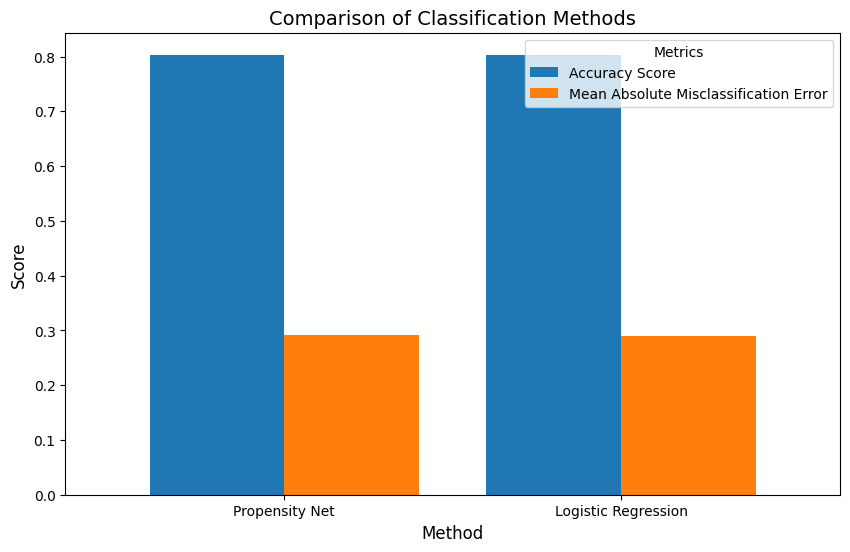

In [46]:
data = {
    'Method': ['Propensity Net', 'Logistic Regression'],
    'Accuracy Score': [accuracy_score_propensity_net, accuracy_score_logistic_regression],
    'Mean Absolute Misclassification Error': [mae_propensity_net, mae_logistic_regression]
}

df_plot = pd.DataFrame(data)

# Plotting
ax = df_plot.plot(kind='bar', x='Method', figsize=(10, 6), width=0.8)

# Set labels and title
ax.set_xlabel("Method", fontsize=12)
ax.set_ylabel("Score", fontsize=12)
ax.set_title("Comparison of Classification Methods", fontsize=14)

# Rotate x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Adding legend
ax.legend(title="Metrics")

# Show the plot
plt.show()

# Deep Learning for Causal Inference

This README summarizes the key points and contributions of the paper "Deep Learning for Causal Inference" by Vikas Ramachandra.

## 1. Generalized Neighbor Matching using Autoencoders

The paper proposes using autoencoders, a type of deep neural network, for dimensionality reduction while preserving the local neighborhood structure of the data. This is useful for generalized neighbor matching to estimate individual treatment effects (ITEs).

The key points are:

* In high dimensions, traditional neighbor matching methods like k-nearest neighbors struggle
* Autoencoders can learn a low-dimensional representation that captures the manifold structure
* This low-dimensional encoding preserves local neighborhoods for accurate neighbor identification
* Experiments show autoencoders outperform methods like manifold learning for ITE estimation

## 2. Deep Neural Networks (DNNs) for Propensity Score Matching

Propensity score matching is a popular technique, but traditionally uses logistic regression for propensity score estimation. The paper proposes using deep neural network classifiers instead, presenting a model called PropensityNet.

The key points are:

* DNNs can potentially capture complex non-linear relationships better than logistic regression
* PropensityNet is trained to estimate propensity scores as a binary classification problem
* Experiments show PropensityNet outperforms logistic regression for propensity score estimation
* This leads to better matching of treated and untreated units for ITE calculation

## Overall Contribution

The paper argues that deep learning models like autoencoders and DNNs can improve upon traditional methods for neighbor matching and propensity score estimation, two crucial steps in causal inference for estimating individual and average treatment effects.

The main contributions are introducing these deep learning approaches, evaluating them on simulated datasets, and demonstrating their potential advantages over existing techniques through experimental results.